#  Travaux pratique sur les volumes finis 2D

* Faire un programme qui résoud - div(grad U) = f 
* Faire le programme qui teste cette fonction

# Importation des librairies

In [1]:
%matplotlib inline
from scipy import sparse
import scipy.linalg
import scipy.sparse.linalg as spspl
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import itertools 
from matplotlib import cm
import seaborn as sb
from math import pow, exp



## Définition du solveur

In [2]:
class SolveurVF2D:
    def solve(self,n, m, f, g):
        l = 1/n 
        k = 1/m
        d = k/l
        e = l/k

        #calcul de la diagonale principale
        main_diag = [2 *(d+e) for _ in range(0,(n-1)*(m-1))]

        #diagonale négative
        last_negativ_diag = [-1 * e for _ in range(0, (n-1)*(m-1) -(n-1))]

        #dernière diagonale positive
        last_positive_diag = [-1 * e for _ in range(0,(n-1)*(m-1) -(n-1))]

        #les deux diagonales intermédiaires et le second membre
        upper_diag = [ 0 if i%(n-1)==0 else (-1 * d) for i in range(1, (n-1)*(m-1) )]

        second_member = [0 for _ in range(0, (n-1)*(m-1))]
        for j in range(1,m):
                for i in range(1,n):
                    num_ord = (n-1)*(j-1)+(i-1)
                    second_member[num_ord] = f(i*l - (l/2), j*k - (k/2)) * k * l
                    if(i == 1):
                        second_member[num_ord] =second_member[num_ord] + d*g(0,j*k)
                    if(i == n-1):
                        second_member[num_ord] =second_member[num_ord] + d*g(1,j*k)
                    if(j==1):
                        second_member[num_ord] =second_member[num_ord] + e*g(i*l,0)
                    if(j==m-1):
                        second_member[num_ord] =second_member[num_ord] + e*g(i*l,1)

        second_member = np.array(second_member)
        self.matrix = sparse.diags([main_diag, upper_diag, upper_diag, last_negativ_diag, last_positive_diag], [0,-1,1,-(n-1),(n-1)])
        self.matrix = self.matrix.tocsc()

        print(self.matrix.todense())
        #print(second_member)
        #resolution
        op = spspl.splu(self.matrix)
        u = op.solve(second_member)
        return u
    
    #fonction pour afficher le graphique de la solution exacte et le graphique de la solution calculée
    def draw_courbe(self,u, f, n,m):
        solution = SolveurVF2D().solve(n,m,f, u)
        solution = solution.reshape(m-1,n-1)
        h = 1./n
        k = 1./m
        A = np.array([u(i*h, 0) for i in range(1,n)]).reshape(1,n-1)
        B = np.array([u(i*h, 1) for i in range(1,n)]).reshape(1,n-1) 
        
        C= np.array([u(0,j*k) for j in range(0,m+1)]).reshape(m+1,1) 
        D= np.array([u(1,j*k) for j in range(0,m+1)]).reshape(m+1,1)
        
            
        solution = np.concatenate((A, solution), axis=0)
        solution = np.concatenate((solution,B), axis=0)
        solution = np.concatenate((solution,D), axis=1)
        solution = np.concatenate( (C,solution), axis=1)
        
        
        solution_exacte = np.zeros((m+1,n+1))
        for i in range(0,n+1):
            for j in range(0,m+1):
                if(i==0 or i==n or j==0 or j==m):
                    solution_exacte[j][i] = u(i*h, j*k)
                else:
                    solution_exacte[j][i] = u(i*(1/n), j*(1/m))
        #print(solution)
        #print(solution_exacte)
        
        #solution calculée
        
        ax1 = plt.axes()
        sb.heatmap(solution, ax=ax1)
        ax1.set_title('Solution calculée')
        plt.show()
        #solution exacte
        ax2 = plt.axes()
        heat_map2 = sb.heatmap(solution_exacte, ax=ax2)
        ax2.set_title('Solution Exacte')
        plt.show()
        #erreur
        errors = np.abs(solution-solution_exacte)
        ax2 = plt.axes()
        sb.heatmap(errors, ax=ax2, cmap="YlGnBu")
        ax2.set_title('Erreurs')
        
    
    #Fonciton permettant d'afficher la courbe des erreurs 
    def draw_error_courbe(self, u, f,Nmax):
        errors_list = []
        errors_log_list = []
        for n in range(4,Nmax):
            h = 1/n
            U_exact = [0 for i in range(0,(n-1)*(n-1))]
            for i in range(1,n):
                for j in range(1,n):
                    num_ord = (n-1)*(j-1)+(i-1)
                    U_exact[num_ord-1] = u(i*h, j*h)
            u_approch = self.solve(u,n,n, f)
            errors_list.append(np.amax(np.absolute(np.subtract(U_exact, u_approch))))
            errors_log_list.append(np.log(np.amax(np.absolute(np.subtract(U_exact, u_approch)))))
        plt.plot([ 1/i for i in range(4,Nmax)], errors_list, color="red")
        plt.xlabel("1/n")
        plt.ylabel("error : ||u-u_bar||")
        plt.title("Courbe des erreurs en fonction de 1/n")
        plt.show()
        plt.plot([ np.log(1/i) for i in range(4, Nmax)], errors_log_list, color="orange")
        plt.xlabel("log(1/n)")
        plt.ylabel("log(error) : log||u-u_bar||")
        plt.title("Courbe du log des erreurs en fonction de log(1/n)")
        plt.show()


        

[[ 4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.    0.    0.    0.  ]
 [-1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.  ]
 [ 0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.  ]
 [ 0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.  ]
 [ 0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.  ]
 [ 0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.  ]
 [ 0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25]
 [ 0.    0.    0.    0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1 ]]


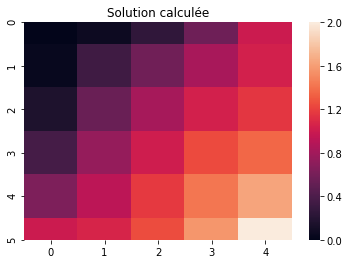

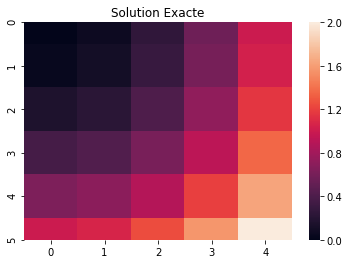

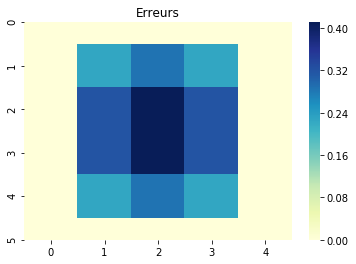

In [3]:
#Donnée de test pour un scénario d'une fonction polynômile
SolveurVF2D().draw_courbe(lambda x,y:x**2+y**2 , lambda x,y:-6*x-6*y, n,m)

[[ 4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.    0.    0.    0.  ]
 [-1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.  ]
 [ 0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.  ]
 [ 0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.  ]
 [ 0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.  ]
 [ 0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.  ]
 [ 0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25]
 [ 0.    0.    0.    0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1 ]]


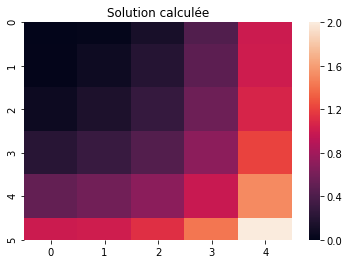

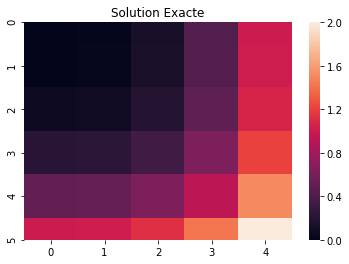

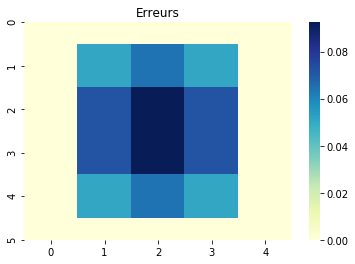

In [4]:
#données pour le scénario d'une fonction polynômiale
SolveurVF2D().draw_courbe(lambda x,y:x**3+y**3 , lambda x,y:-6*x-6*y, n,m)

[[ 4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.    0.    0.    0.  ]
 [-1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.  ]
 [ 0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.  ]
 [ 0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.  ]
 [ 0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.  ]
 [ 0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.  ]
 [ 0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25]
 [ 0.    0.    0.    0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1 ]]


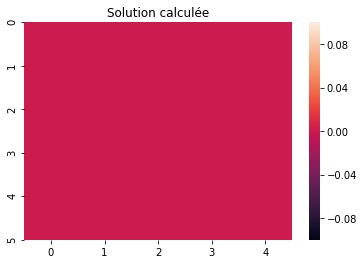

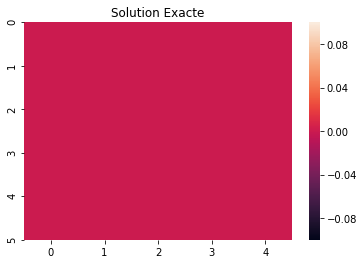

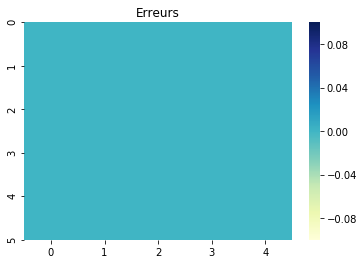

In [5]:
#données pour le scénario d'une fonction nul
SolveurVF2D().draw_courbe(lambda x,y:0, lambda x,y:0, n,m)

[[ 4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.    0.    0.    0.  ]
 [-1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.  ]
 [ 0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.  ]
 [ 0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.  ]
 [ 0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.  ]
 [ 0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.  ]
 [ 0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25]
 [ 0.    0.    0.    0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1 ]]


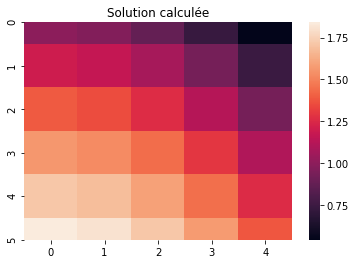

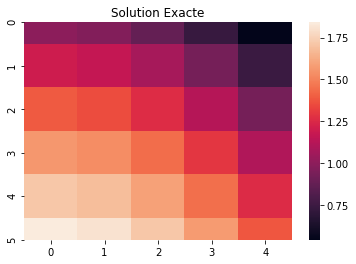

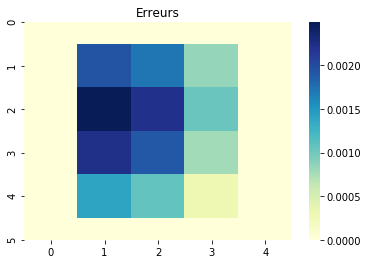

In [6]:
#données pour le scénario d'une fonction non polynômiale
SolveurVF2D().draw_courbe(lambda x,y:np.cos(x)+np.sin(y), lambda x,y:np.cos(x)+np.sin(y), n,m)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


[[ 4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.    0.    0.    0.  ]
 [-1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.    0.    0.    0.  ]
 [ 0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.    0.    0.    0.  ]
 [ 0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25  0.    0.    0.  ]
 [ 0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.   -1.25  0.    0.  ]
 [ 0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8   0.   -1.25  0.  ]
 [ 0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1   0.    0.   -1.25]
 [ 0.    0.    0.    0.    0.    0.   -1.25  0.    0.    4.1  -0.8   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1  -0.8 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.25  0.   -0.8   4.1 ]]


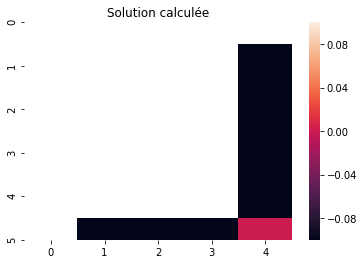

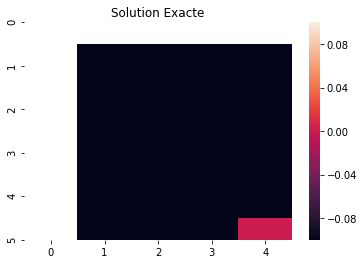

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in subtract


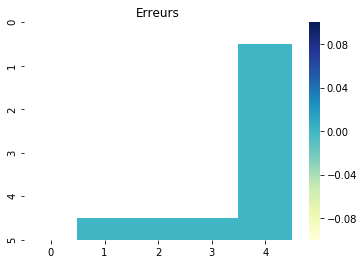

In [8]:
#données pour le scénario d'une fonction logarithmique
SolveurVF2D().draw_courbe(lambda x,y:np.log(x)+np.log(y), lambda x,y:1/x**2+1/y**2, n,m)